# Installing/Importing the required libraries

In [ ]:
#!apt-get install openslide-tools

In [ ]:
pip install pydicom

Train and test datasets have DICOM images. Therefore this library is used.


In [ ]:
#!apt-get install python3-openslide


In [ ]:
!pip install openslide-python

In [ ]:
#Importing necessary libraries
import pylab
import csv
import random
from skimage import measure
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras
import skimage.exposure

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import pydicom 
%matplotlib inline 
import os
import glob
import warnings
import multiprocessing
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import util
from skimage import transform
from google.colab import drive
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
import sklearn
from sklearn.metrics import precision_recall_curve
from sklearn import metrics

warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Mounting the Drive

In [ ]:
#Mounting the drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
#Set the project path 
project_path = '/content/drive/My Drive/AIML/Datasets/'
os.chdir(project_path)

In [ ]:
#Loading the images
images_path = ("/content/drive/My Drive/AIML/Datasets/stage_2_train_images")
#images_path = ("/content/drive/My Drive/AIML/Datasets/filtered_train_images")

# Pre-Processing

**Create a list of files with positive pneumonia cases**

In [ ]:
##Scan the entire list of files in the CSV and fetch the filenames with positive pneumonia cases. 
##Create their list along with the locations of the bounding boxes.

# empty dictionary
nodule_locations = {}
# load table
with open(os.path.join("/content/drive/My Drive/AIML/Datasets/stage_2_train_labels.csv"), mode='r') as infile:
    reader = csv.reader(infile)
    # skip header
    next(reader, None)

    for rows in reader:
        filename = rows[0]
        location = rows[1:5]
        nodule = rows[5]
        # if row contains a nodule add label to dictionary
        # which contains a list of nodule locations per filename
        if nodule == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save nodule location in dictionary
            if filename in nodule_locations:
                nodule_locations[filename].append(location)
            else:
                nodule_locations[filename] = [location]

# Create the Train, Validation and Test data

In [ ]:
folder = "/content/drive/My Drive/AIML/Datasets/stage_2_train_images"
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2000
test_samples = 1000
train_filenames = filenames[n_valid_samples+test_samples:]
valid_filenames = filenames[test_samples:n_valid_samples+test_samples]
test_filenames = filenames[:test_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples - test_samples

n train samples 23733
n valid samples 2000


# Define Generator

In [ ]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, nodule_locations=None, batch_size=32, image_size=128, shuffle=True, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.nodule_locations = nodule_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        #msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains nodules
        if filename in nodule_locations:
            # loop through nodules
            pneumonia=1
        else:
            pneumonia=0
                
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        #msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        #msk = np.expand_dims(msk, -1)
        return img,pneumonia # ,msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, pneumonia = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            #imgs= [skimage.transform.resize(imgs, (128,128,1))]   
            pneumonia = np.array(pneumonia)
            #pneumonia=pneumonia.reshape(16,1,1,1)
            return imgs,pneumonia #, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

**Create Train and Validation Generators**

In [ ]:
# create train and validation generators
folder = "/content/drive/My Drive/AIML/Datasets/stage_2_train_images"
train_gen = generator(folder, train_filenames, nodule_locations, batch_size=16, image_size=128, shuffle=True, predict=False)
valid_gen = generator(folder, valid_filenames, nodule_locations, batch_size=16, image_size=128, shuffle=False, predict=False)

# Build the Model

In [ ]:
def identity_block(inputs,kernel_size,filters):    
    filters1, filters2, filters3 = filters
    
    x = keras.layers.Conv2D(filters1, (1, 1)) (inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x = keras.layers.Conv2D(filters2, kernel_size,
               padding='same')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    x =keras.layers.Conv2D(filters3, (1, 1))(x)
    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.add([x, inputs])
    x = keras.layers.ReLU()(x)
    return x

In [ ]:
def webnet(input_size):
    inputs= keras.Input(shape=(input_size, input_size, 1))
    conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(inputs)
    #conv1 = Dropout(0.5)(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    #conv1 = Dropout(0.5)(conv1)
    conv1 = keras.layers.BatchNormalization()(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    
    conv2=identity_block(pool1,3,[64,64,64])
    #conv2 = Dropout(0.5)(conv2)
    conv2 = identity_block(conv2,3,[64,64,64])
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = identity_block(pool2,3,[32,32,64])
    #conv3 = Dropout(0.5)(conv3)
    conv3 = identity_block(conv3,3,[32,32,64])
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = identity_block(pool3,3,[32,32,64])
    #conv4 = Dropout(0.5)(conv4)
    conv4 = identity_block(conv4,3,[32,32,64])
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = identity_block(pool4,3,[32,32,64])
    #conv5 = Dropout(0.5)(conv5)
    conv5 = identity_block(conv5,3,[32,32,64])
    conv5 = identity_block(conv5,3,[32,32,64])

    up6 = keras.layers.Concatenate(axis=-1)([keras.layers.UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(up6)
    conv6 = identity_block(conv6,3,[32,32,64])
    #conv6 = Dropout(0.5)(conv6)
    conv6 = identity_block(conv6,3,[32,32,64])

    up7 = keras.layers.Concatenate(axis=-1)([keras.layers.UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(up7)
    conv7 = identity_block(conv7,3,[32,32,64])
    #conv7 = Dropout(0.5)(conv7)
    conv7 = identity_block(conv7,3,[32,32,64])
    pool7 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv7)

    concat8 = keras.layers.Concatenate(axis=-1)([pool7, conv6])
    conv8 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(concat8)
    conv8 = identity_block(conv8,3,[32,32,64])
    #conv8 = Dropout(0.5)(conv8)
    conv8 = identity_block(conv8,3,[32,32,64])
    pool8 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv8)

    concat9 =keras.layers.Concatenate()([pool8, conv5])
    conv9 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(concat9)
    conv9 = identity_block(conv9,3,[32,32,64])
    #conv9 = Dropout(0.5)(conv9)
    conv9 = identity_block(conv9,3,[32,32,64])
    #conv9 = Dropout(0.5)(conv9)
       
    up10 = keras.layers.Concatenate(axis=-1)([keras.layers.UpSampling2D(size=(2, 2))(conv9), conv8])
    conv10 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(up10)
    conv10 = identity_block(conv10,3,[32,32,64])
    #conv10 = Dropout(0.5)(conv6)
    conv10 = identity_block(conv10,3,[32,32,64])
    
    up11 = keras.layers.Concatenate(axis=-1)([keras.layers.UpSampling2D(size=(2, 2))(conv10), conv7])
    conv11 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(up11)
    conv11 =identity_block(conv11,3,[32,32,64])
    #conv11 = Dropout(0.5)(conv11)
    conv11 = identity_block(conv11,3,[32,32,64])
    pool11 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv11)
    
    concat12 = keras.layers.Concatenate()([pool11, conv10])
    conv12 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(concat12)
    conv12 = identity_block(conv12,3,[32,32,64])
    #conv12 = Dropout(0.5)(conv12)
    conv12 = identity_block(conv12,3,[32,32,64])
    pool12 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv12)
    
    concat13 = keras.layers.Concatenate(axis=-1)([pool12, conv9])
    conv13 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(concat13)
    conv13 = identity_block(conv13,3,[32,32,64])
    #conv13 = Dropout(0.5)(conv13)
    conv13 = identity_block(conv13,3,[32,32,64])
     
    up14 = keras.layers.Concatenate(axis=-1)([keras.layers.UpSampling2D(size=(2, 2))(conv13), conv12])
    conv14 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(up14)
    conv14 = identity_block(conv14,3,[32,32,64])
    conv14 = identity_block(conv14,3,[32,32,64])
    
    up15 = keras.layers.Concatenate(axis=-1)([keras.layers.UpSampling2D(size=(2, 2))(conv14), conv11])
    conv15 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(up15)
    conv15 = identity_block(conv15,3,[32,32,64])
    #conv15 = Dropout(0.5)(conv15)
    conv15 = identity_block(conv15,3,[32,32,64])
    
    up16 = keras.layers.Concatenate(axis=-1)([keras.layers.UpSampling2D(size=(2, 2))(conv15), conv2])
    conv16 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(up16)
    conv16 = identity_block(conv16,3,[32,32,64])
    #conv16 = Dropout(0.5)(conv16)
    conv16 = identity_block(conv16,3,[32,32,64])
    
    up17 = keras.layers.Concatenate(axis=-1)([keras.layers.UpSampling2D(size=(2, 2))(conv16), conv1])
    conv17 = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same')(up17)
    conv17 = identity_block(conv17,3,[32,32,64])
    #conv17 = Dropout(0.5)(conv17)
    #conv17 = AveragePooling2D((7, 7))(conv17)
    conv17 = keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(conv17)
    flat1=keras.layers.Flatten()(conv17)
    dense1= keras.layers.Dense(1, activation='sigmoid')(flat1)
    model = keras.Model(inputs=inputs, outputs=dense1)

    return model

In [ ]:
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

In [ ]:
# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

In [ ]:
# mean iou as a metric
def mean_iou_webnet(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1])
    union = tf.reduce_sum(y_true, axis=[1]) + tf.reduce_sum(y_pred, axis=[1])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))


# Compile the Model

In [ ]:
model_webnet = webnet(input_size=128)
model_webnet.load_weights("/content/drive/My Drive/AIML/model.h5")
model_webnet.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy',mean_iou_webnet])

In [ ]:
model_webnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#model_webnet.layers
#368 layers

**Define learning rate and early stopping**

In [ ]:
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)


In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
# stop = EarlyStopping(monitor="loss", patience=5, mode="min")
# checkpoint = ModelCheckpoint(os.path.join('web_softmax_bce_SGD.hdf5'),
#                                            monitor='val_loss', mode='min', save_best_only=True, 
#                                            save_weights_only=False, verbose=0)

# Running the Model

In [ ]:
# model_info=model_webnet.fit_generator(
#  train_gen,
#     steps_per_epoch=200,
#     epochs=10,
#     validation_data=valid_gen,
#     validation_steps=50,
#      callbacks=[tf.keras.callbacks.CSVLogger(os.path.join('training_web_log.csv'), append=True),
#                                          checkpoint,learning_rate,stop])

**Save the weights**

In [ ]:
#model_webnet.save_weights("/content/drive/My Drive/AIML/model.h5")

# Predict the Output for One Sample Image

**Original Image**

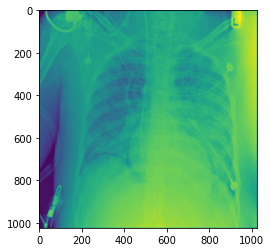

In [ ]:
metadata = pydicom.read_file(images_path+'/'+test_filenames[0])
sample_image = metadata.pixel_array
sample_image.shape
plt.imshow(sample_image)

**Creating the test data to provide as input for prediction**

In [ ]:
#Try predicting a single image file first
sample_image = resize(sample_image, (128, 128), mode='reflect')
# add trailing channel dimension
sample_image = np.expand_dims(sample_image, -1)
test_data = []
test_data.append(sample_image)
test_data = np.array(test_data)
test_data[0].shape

(128, 128, 1)

In [ ]:
#Predict for the sample image
y_predict = model_webnet.predict(test_data)
y_predict

array([[0.48251098]], dtype=float32)

# Predict For Entire Test Set

In [ ]:
##### New prediction Code - To run on entire test set
## Create an array of test images: test_data
## Create an array of labels for test data: test_labels
## Use test_data to get a prediction
## Use test_labels to calculate the accuracy, precision and recall

test_labels = []
test_data = []
for test_file in test_filenames:
  img = pydicom.dcmread(os.path.join(folder, test_file)).pixel_array
  img = resize(img, (128, 128), mode='reflect')

  test_file = test_file.split('.')[0]
  if test_file in nodule_locations:
    label = 1
  else:
    label = 0
  test_labels.append(label)
  test_data.append(img)
 
test_labels = np.array(test_labels)
test_data = np.array(test_data)

In [ ]:
# Predict for entire test set
y_predict = model_webnet.predict(test_data)

In [ ]:
y_predict[10:15]

array([[0.09798399],
       [0.2784703 ],
       [0.08329991],
       [0.43141395],
       [0.22767322]], dtype=float32)

# Model Evaluation

In [ ]:
true_positive = 0
true_negative = 0
false_positive = 0
false_negative = 0
for i in range(1000):
    if (y_predict[i]   >= 0.42 and test_labels[i] == 1):
        true_positive +=1
    if (y_predict[i]  < 0.42 and test_labels[i] == 0):
        true_negative +=1
    if (y_predict[i]   >= 0.42 and test_labels[i] == 0):
        false_positive += 1 
    if (y_predict[i]  < 0.42 and test_labels[i] == 1):
        false_negative += 1

In [ ]:
print(true_positive, false_positive, true_negative, false_negative)

106 102 689 103


**Precision & Recall**

In [ ]:
precision = true_positive / ( true_positive + false_positive)
recall = true_positive / (true_positive + false_negative )
accuracy = ( true_positive + true_negative)/ (true_positive + true_negative + false_positive + false_negative)

In [ ]:
print ('precision :' , precision)
print ('recall :', recall)
print ('accuracy :', accuracy)

precision : 0.5096153846153846
recall : 0.507177033492823
accuracy : 0.795


# ROC Curve

In [ ]:
# Calculating thresolds usings Precision_recall_curve
scores = np.array([true_positive, true_negative, false_positive, false_negative])
fpr, tpr, thresholds = metrics.roc_curve(test_labels, y_predict)
#print(fpr, tpr)

In [ ]:
roc_auc = metrics.auc(fpr, tpr)
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

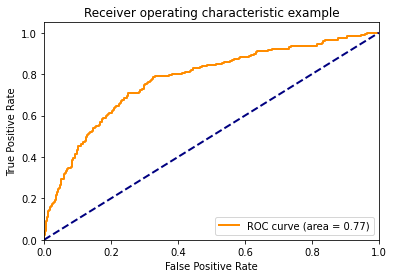

In [ ]:
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()